# Reference frames

rigid_body_motion provides a flexible high-performance framework for working offline with motion data.

In [1]:
import numpy as np
import rigid_body_motion as rbm

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


<div class="alert alert-info">
Note
    
The following examples require the `matplotlib` library.
</div>

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Static frames

In [3]:
rf_world = rbm.ReferenceFrame("world")

In [4]:
rf_observer = rbm.ReferenceFrame(
    "observer", parent=rf_world, translation=(5, 0, 0), rotation=(0, 0, 0, 1)
)

In [5]:
rbm.render_tree(rf_world)

world
└── observer


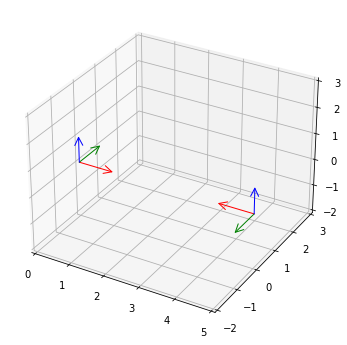

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)


In [7]:
rf_world.register()
rf_observer.register()
rbm.registry

{'world': <ReferenceFrame 'world'>, 'observer': <ReferenceFrame 'observer'>}

## Transforming position and orientation

In [8]:
position = np.zeros((10, 3))
position[:, 0] = np.linspace(0, 5, 10)
position[:, 0]

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

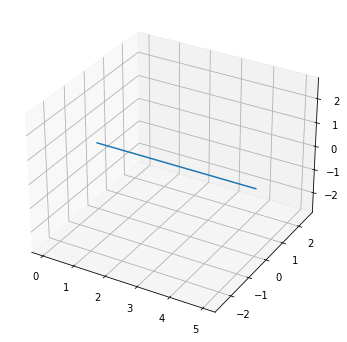

In [9]:
rbm.plot.points(position)

In [10]:
p_wrt_observer = rbm.transform_points(position, outof="world", into="observer")
p_wrt_observer[:, 0]

array([5.        , 4.44444444, 3.88888889, 3.33333333, 2.77777778,
       2.22222222, 1.66666667, 1.11111111, 0.55555556, 0.        ])

In [11]:
orientation = np.tile([1, 0, 0, 0], (10, 1))
rbm.transform_quaternions(orientation, outof="world", into="observer")

array([[ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.]])

## Moving frames

In [12]:
timestamps = np.arange(10)

In [13]:
rbm.register_frame("body", translation=position, timestamps=timestamps, parent="world")
rbm.render_tree("world")

world
├── observer
└── body


In [14]:
p_wrt_body, ts = rbm.transform_points([1, 0, 0], outof="world", into="body")
p_wrt_body[:, 0]

array([ 1.        ,  0.44444444, -0.11111111, -0.66666667, -1.22222222,
       -1.77777778, -2.33333333, -2.88888889, -3.44444444, -4.        ])

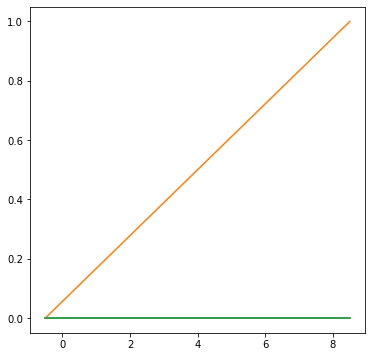

In [15]:
position_2 = np.zeros((10, 3))
position_2[:, 1] = np.linspace(0, 1, 10)
timestamps_2 = timestamps - 0.5
plt.plot(timestamps_2, position_2)

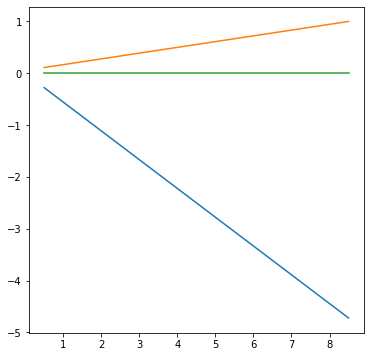

In [16]:
p2_wrt_body, ts = rbm.transform_points(
    position_2, outof="world", into="body", timestamps=timestamps_2
)
plt.plot(ts, p2_wrt_body)

## Looking up transforms and velocities

In [17]:
rbm.lookup_transform("body", "world")

(array([[ 0.        ,  0.        ,  0.        ],
        [-0.55555556,  0.        ,  0.        ],
        [-1.11111111,  0.        ,  0.        ],
        [-1.66666667,  0.        ,  0.        ],
        [-2.22222222,  0.        ,  0.        ],
        [-2.77777778,  0.        ,  0.        ],
        [-3.33333333,  0.        ,  0.        ],
        [-3.88888889,  0.        ,  0.        ],
        [-4.44444444,  0.        ,  0.        ],
        [-5.        ,  0.        ,  0.        ]]),
 array([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [18]:
rbm.lookup_twist("body", "world")

(array([[0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ],
        [0.55555556, 0.        , 0.        ]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

## Transforming velocities

## Discrete frames